In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [32]:
#import the data
data_jobs = pd.read_excel("DataJobs.xlsx")

In [33]:
#Visualize the data
data_jobs.head()

,Survey Year,Timestamp,SalaryUSD,Country,PostalCode,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,...,NewestVersionInProduction,OldestVersionInProduction,PopulationOfLargestCityWithin20Miles,EmploymentSector,LookingForAnotherJob,CareerPlansThisYear,Gender,OtherJobDuties,KindsOfTasksPerformed,Counter
0,2023,2022-11-22 05:28:48.096,190000.0,United States,NaN,Microsoft SQL Server,20,"MySQL/MariaDB, SQLite","Independent consultant, contractor, freelancer...","Developer: App code (C#, JS, etc)",...,Not Asked,Not Asked,300K-1M (large city),Private business,Not Asked,Prefer not to say,Male,Not Asked,Not Asked,1
1,2023,2022-11-22 05:33:28.389,100000.0,Canada,NaN,Microsoft SQL Server,0,NaN,Full time employee,DBA (General - splits time evenly between writ...,...,Not Asked,Not Asked,1M+ (metropolis),Private business,Not Asked,"Stay with the same employer, same role",Male,Not Asked,Not Asked,1
2,2023,2022-11-22 05:33:41.931,135000.0,United States,33764,Microsoft SQL Server,6,Azure SQL DB (any flavor),Full time employee,Architect,...,Not Asked,Not Asked,1M+ (metropolis),Private business,Not Asked,"Stay with the same role, but change employers",Male,Not Asked,Not Asked,1
3,2023,2022-11-22 05:39:33.345,30000.0,Poland,05-800,Microsoft SQL Server,5,NaN,Full time employee,"DBA (Development Focus - tunes queries, indexe...",...,Not Asked,Not Asked,1M+ (metropolis),Private business,Not Asked,"Stay with the same role, but change employers",Male,Not Asked,Not Asked,1
4,2023,2022-11-22 05:43:51.939,70000.0,United States,72335,Microsoft SQL Server,3,NaN,Full time employee,Developer: T-SQL,...,Not Asked,Not Asked,1M+ (metropolis),"Education (K-12, college, university)",Not Asked,Prefer not to say,Male,Not Asked,Not Asked,1


In [34]:
# Remove unwanted columns
data_jobs.drop(['PostalCode','Timestamp','OtherDatabases','OtherPeopleOnYourTeam','Certifications','NewestVersionInProduction','OldestVersionInProduction','LookingForAnotherJob','Counter' ],inplace=True, axis=1)


In [35]:
#Clean data
data_jobs = data_jobs[data_jobs["SalaryUSD"]>4999] #Delete Salaries below 5000 dollars yearly
#Clean the values 1
data_jobs["HowManyCompanies"] = data_jobs["HowManyCompanies"].apply(lambda x: x.replace(" (this is the only company where I've had this kind of position)","") if x == "1 (this is the only company where I've had this kind of position)" else x ) 
#Clean the values 2
data_jobs["HowManyCompanies"] = data_jobs["HowManyCompanies"].apply(lambda x: x.replace(" (I worked at another similar position elsewhere before this one)","") if x == "2 (I worked at another similar position elsewhere before this one)" else x )


In [36]:
print(data_jobs.shape)
data_jobs.head()
data_jobs.to_excel("data_jobs.xlsx")

(12126, 22)


# Hypothesis 1

In [37]:
#Hypothesis
# a = mu_Salaries(People that changed jobs <=3 times) 
# b = mu_Salaries(People that changed jobs > 3 times)

# H0: b <= a
# H1: b > a

In [38]:
#Significance
alpha = 0.05

In [39]:
#Filter the sample to not consider the ones that was not asked
sample = data_jobs[["SalaryUSD","HowManyCompanies"]]
sample = sample[sample["HowManyCompanies"] != "Not Asked"]
#Grouping the 1 to 3 years and the rest in two values
sample["HowManyCompanies"] = sample["HowManyCompanies"].apply(lambda x: "Less or equal to 3" if x in ["1","2","3"] else "More than 3" )
# Dividing the salaries in to variables
a = sample[sample["HowManyCompanies"] == "Less or equal to 3" ]["SalaryUSD"]
b = sample[sample["HowManyCompanies"] == "More than 3" ]["SalaryUSD"]


In [40]:
#calculating the p-value
p_value = st.ttest_ind(b,a, equal_var = False, alternative = "greater")[1]

In [41]:
# Confirm that the hypothesis was rejected or not
if p_value < alpha:
    print("We can reject the null hypothesis")
else:
    print("We can not reject the null")

We can reject the null hypothesis


# Hypothesis 2


In [42]:
#Hypothesis
#H0 : Being Manager is independent of gender

#H1 : Being Manager is dependent of gender




In [43]:
#Significance
alpha = 0.05

In [44]:
#Filtering dataset to only gender and manager column and take the not asked 
sample2 = data_jobs[["ManageStaff","Gender"]]
sample2 = sample2[sample2["Gender"] != "Not Asked"]

In [45]:
#Group by the manage staff and gender and count the number of people
sample2 = sample2.groupby(["ManageStaff","Gender"]).agg({"ManageStaff":"count"})
sample2.rename(columns = {'ManageStaff':'count'}, inplace = True)

In [46]:
#Pivot the groupby dataframe to pass the gender to columns
sample2 = sample2.reset_index().pivot(index='ManageStaff', columns='Gender', values='count')


In [47]:
sample2 = sample2.reset_index()
sample2

Gender,ManageStaff,Female,Male,Non-binary/third gender,Prefer not to say
0,No,715,6252,27,106
1,Yes,168,1933,8,32


In [48]:
#Turning the dataframe to an array
managers =np.array(sample2.iloc[0:, 1:4])
managers

array([[ 715, 6252,   27],
       [ 168, 1933,    8]], dtype=int64)

In [49]:
p_value = st.chi2_contingency(managers)[1]

In [50]:
# Confirm that the hypothesis was rejected or not
if p_value < alpha:
    print("We can reject the null hypothesis")
else:
    print("We can not reject the null")

We can reject the null hypothesis


# Hypothesis 3


In [51]:
#Hypothesis
#H0 : People that live in big cities work less hours

#H1 : People that live in big cities work more hours

In [52]:
sample3 = data_jobs[["HoursWorkedPerWeek","PopulationOfLargestCityWithin20Miles"]]
sample3 = sample3[sample3["PopulationOfLargestCityWithin20Miles"] != "Not Asked"]
sample3 = sample3[sample3["HoursWorkedPerWeek"] != "Not Asked"]
sample3["PopulationOfLargestCityWithin20Miles"].value_counts()

PopulationOfLargestCityWithin20Miles
1M+ (metropolis)        326
300K-1M (large city)    283
100K-299K (city)        162
20K-99K (large town)     82
<= 20,000 (town)         21
Name: count, dtype: int64

In [53]:
#Divide the hours worked by cities
large_city = []
metropolis = []
city = []
large_town = []
town = []
for item1,item2 in zip(sample3["HoursWorkedPerWeek"],sample3["PopulationOfLargestCityWithin20Miles"]):
    if item2 == "300K-1M (large city)":
        large_city.append(item1)
    elif item2 == "1M+ (metropolis)":
        metropolis.append(item1)
    elif item2 == "100K-299K (city)":
        city.append(item1)
    elif item2 == "20K-99K (large town)":
        large_town.append(item1)
    else:
        town.append(item1)

In [54]:
#H0: mu_large_city = mu_metropolis = mu_city  = mu_large_town = mu_town
# H1 ~(mu_large_city = mu_metropolis = mu_city  = mu_large_town = mu_town)

alpha = 0.05

p_value = st.f_oneway(large_city,metropolis,city,large_town,town)[1]

In [55]:
# Confirm that the hypothesis was rejected or not
if p_value < alpha:
    print("We can reject the null hypothesis")
else:
    print("We can not reject the null")

We can reject the null hypothesis


In [61]:
print(np.array(large_city).mean())
print(np.array(metropolis).mean())
print(np.array(city).mean())
print(np.array(large_town).mean())
print(np.array(town).mean())

42.41696113074205
44.14110429447853
41.98765432098765
42.951219512195124
44.142857142857146


In [66]:
# Correlation beetween hoursworked and salary
sample4 = data_jobs[["SalaryUSD","HoursWorkedPerWeek"]]
sample4 = sample4[sample4["HoursWorkedPerWeek"] != "Not Asked"]
sample4.head(10)

,SalaryUSD,HoursWorkedPerWeek
5333,128500.0,40
5334,52922.0,38
5335,110000.0,44
5336,73000.0,40
5337,65000.0,45
5338,70000.0,38
5339,116500.0,30
5340,67000.0,37
5341,124000.0,40
5342,33172.0,40


In [68]:
sample4.corr()

,SalaryUSD,HoursWorkedPerWeek
SalaryUSD,1.000000,0.161249
HoursWorkedPerWeek,0.161249,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

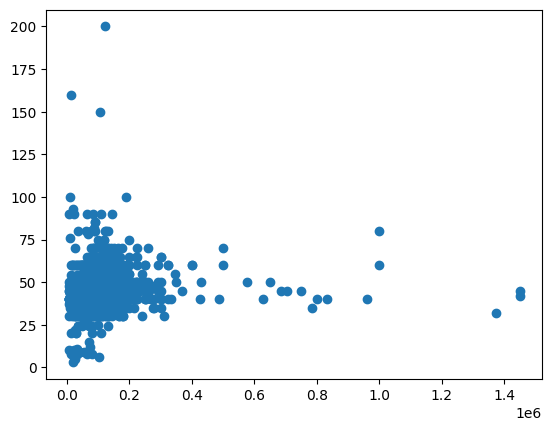

In [70]:
x = sample4[["SalaryUSD"]]

y = sample4["HoursWorkedPerWeek"]

plt.scatter(x,y)
plt.show

In [71]:
from sklearn import linear_model 

# we first initialize our model 


model = linear_model.LinearRegression()

# now, we must fit (aka train) the model in our data

result = model.fit(x,y)

<function matplotlib.pyplot.show(close=None, block=None)>

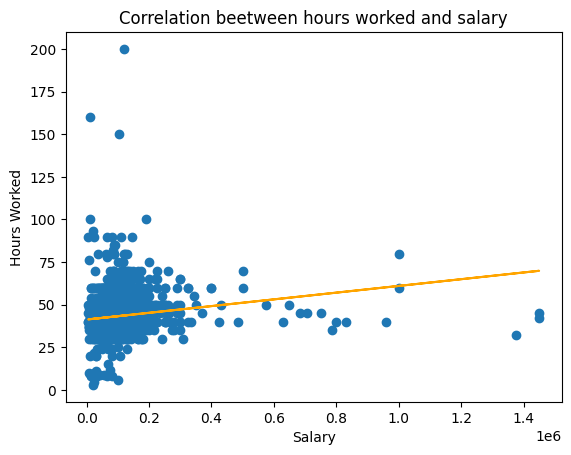

In [74]:
regression_line = result.intercept_ + result.coef_[0]*x

plt.plot(x, regression_line, color = "orange")
plt.scatter(x,y)
plt.xlabel("Salary")
plt.ylabel("Hours Worked")
plt.title("Correlation beetween hours worked and salary")
plt.show